In [0]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
from keras.datasets import mnist, cifar10
from keras.models import Sequential, Model
from keras.layers import Input, Dense, ReLU, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import RMSprop
from keras import initializers
from keras import backend as K

Using TensorFlow backend.


In [0]:
# load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(X_train.shape)
print(y_train.shape)
print(np.unique(y_train))

(50000, 32, 32, 3)
(50000, 1)
[0 1 2 3 4 5 6 7 8 9]


In [0]:
# fig = plt.figure()
# for i in range(10):
#     plt.subplot(2, 5, i+1)
#     x_y = X_train[y_train == i]
#     plt.imshow(x_y[0], cmap='gray', interpolation='none')
#     plt.title("Class %d" % (i))
#     plt.xticks([])
#     plt.yticks([])
    
# plt.tight_layout()

In [0]:
print('X_train.shape', X_train.shape)

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

print('X_train reshape:', X_train.shape)

X_train.shape (50000, 32, 32, 3)
X_train reshape: (50000, 32, 32, 3)


# Define Models

In [0]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28x1
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# FC
generator.add(Dense(2*2*512, input_shape=(latent_dim,), kernel_initializer=init))
# generator.add(ReLU())
generator.add(Reshape((2, 2, 512)))

# # Conv 1
generator.add(Conv2DTranspose(256, kernel_size=3, strides=2, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU(0.2))

# Conv 2
generator.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU(0.2))

# Conv 3
generator.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU(0.2))

# Output
generator.add(Conv2DTranspose(3, kernel_size=3, strides=2, padding='same',
                              activation='tanh'))
# prints a summary representation of your model
generator.summary()













Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 256)         1179904   
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 8, 8, 128)         295040    
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 

In [0]:
# Critic network
critic = Sequential()

# imagem shape 28x28x1
img_shape = X_train[0].shape

# Conv 1
critic.add(Conv2D(64, kernel_size=3, strides=2, padding='same',
                  input_shape=(img_shape)))
critic.add(LeakyReLU(0.2))

# Conv 2
critic.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
critic.add(BatchNormalization(momentum=0.8))
critic.add(LeakyReLU(0.2))

# Conv 3
critic.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
critic.add(BatchNormalization(momentum=0.8))
critic.add(LeakyReLU(0.2))

# Conv 4
critic.add(Conv2D(512, kernel_size=3, strides=1, padding='same'))
critic.add(BatchNormalization(momentum=0.8))
critic.add(LeakyReLU(0.2))

# FC
critic.add(Flatten())

# Output
critic.add(Dense(1))
# prints a summary representation of your model
critic.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
batch_normalization_5 (Batch (None, 4, 4, 256)        

In [0]:
# Wasserstein objective
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [0]:
# Following parameter and optimizer set as recommended in paper
n_critic = 2
clip_value = 0.01
optimizer = RMSprop(lr=0.00005)

critic.compile(optimizer=optimizer, loss=wasserstein_loss, metrics=['accuracy'])

In [0]:
critic.trainable = False

# The generator takes noise as input and generated imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# The critic takes generated images as input and determines validity
valid = critic(img)

# The combined model (critic and generative)
c_g = Model(inputs=z, outputs=valid, name='wgan')

c_g.compile(optimizer=optimizer, loss=wasserstein_loss, metrics=['accuracy'])

In [0]:
# prints a summary representation of your model
c_g.summary()

Model: "wgan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         1759107   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1562753   
Total params: 3,321,860
Trainable params: 1,758,211
Non-trainable params: 1,563,649
_________________________________________________________________


In [0]:
epochs = 50
batch_size = 64

real = -np.ones(shape=(batch_size, 1))
fake = np.ones(shape=(batch_size, 1))

d_loss = []
g_loss = []
d_loss_for_plot = []
g_loss_for_plot = []
for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        for _ in range(n_critic):

            # Train Discriminator weights
            critic.trainable = True

            # Real samples
            X_batch = X_train[i*batch_size:(i+1)*batch_size]
            d_loss_real = critic.train_on_batch(x=X_batch, y=real)

            # Fake Samples
            z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
            X_fake = generator.predict(z)
            d_loss_fake = critic.train_on_batch(x=X_fake, y=fake)

            # Discriminator loss
            d_loss_batch = [x+y for x,y in zip(d_loss_real, d_loss_fake)]
            d_loss_batch = [0.5*x for x in d_loss_batch]

            # Clip critic weights
            for l in critic.layers:
                weights = l.get_weights()
                weights = [np.clip(w, -clip_value, clip_value) for w in weights]
                l.set_weights(weights)

        # Train Generator weights
        critic.trainable = False
        g_loss_batch = c_g.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch[0], g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch[0])
    g_loss.append(g_loss_batch[0])
    d_loss_for_plot.append(d_loss_batch)
    g_loss_for_plot.append(g_loss_batch)
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    # if e % 10 == 0:
    #     samples = 100
    #     x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))
    #     plt.figure(figsize=[11, 11])
    #     for k in range(samples):
    #         plt.subplot(10, 10, k + 1, xticks=[], yticks=[])
    #         plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))

    #     plt.tight_layout()
    #     plt.show()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
epoch = 1/50, d_loss=-0.084, g_loss=0.184                                                                                                     
epoch = 2/50, d_loss=-0.093, g_loss=0.288                                                                                                     
epoch = 3/50, d_loss=-0.029, g_loss=0.263                                                                                                     
epoch = 4/50, d_loss=-0.008, g_loss=0.219                                                                                                     
epoch = 5/50, d_loss=-0.013, g_loss=0.106                                                                                                     
epoch = 6/50, d_loss=-0.007, g_loss=0.082                                                                                                     
epoch = 7/50, d_loss=-0.006, g_loss=0.051     

In [0]:
# # plotting the metrics
# plt.plot(d_loss)
# plt.plot(g_loss)
# epoch = np.arange(len(d_loss))
# d_loss_for_plot = np.array(d_loss_for_plot)
# plt.plot(epoch, d_loss_for_plot[:, 1])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Discriminator', 'Adversarial'], loc='center right')
# plt.show()

In [0]:
g_loss_for_plot

[[0.18441874, 0.0],
 [0.28842062, 0.0],
 [0.2625209, 0.0],
 [0.21891657, 0.0],
 [0.10587322, 0.0],
 [0.0821427, 0.0],
 [0.050536573, 0.0],
 [0.031347882, 0.0],
 [0.020283464, 0.0],
 [0.014773235, 0.0],
 [0.008794675, 0.0],
 [0.008309602, 0.0],
 [0.007632523, 0.0],
 [0.006966159, 0.0],
 [0.0058824876, 0.0],
 [0.005042679, 0.0],
 [0.004989762, 0.0],
 [0.0046394956, 0.0],
 [0.0055091158, 0.0],
 [0.004990341, 0.0],
 [0.00519916, 0.0],
 [0.005487062, 0.0],
 [0.005342462, 0.0],
 [0.005275679, 0.0],
 [0.005360505, 0.0],
 [0.0054518916, 0.0],
 [0.004647107, 0.0],
 [0.00432361, 0.0],
 [0.0041057942, 0.0],
 [0.0044676065, 0.0],
 [0.0038843811, 0.0],
 [0.003489274, 0.0],
 [0.0031585349, 0.0],
 [0.003436004, 0.0],
 [0.0032688053, 0.0],
 [0.0027591551, 0.0],
 [0.0027685273, 0.0],
 [0.0031528855, 0.0],
 [0.002958225, 0.0],
 [0.0021979243, 0.0],
 [0.0024062626, 0.0],
 [0.002427334, 0.0],
 [0.0026845387, 0.0],
 [0.0025860774, 0.0],
 [0.0026168, 0.0],
 [0.0021519996, 0.0],
 [0.0022724937, 0.0],
 [0.002

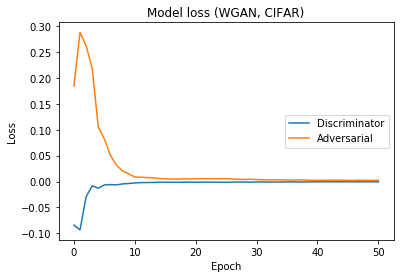

In [0]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss (WGAN, CIFAR)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

In [1]:
d_loss_for_plot = np.array(d_loss_for_plot)
g_loss_for_plot = np.array(g_loss_for_plot)
epochs_for_plot = np.arange(len(g_loss_for_plot))
plt.plot(epochs_for_plot, d_loss_for_plot[:, 1])
plt.plot(epochs_for_plot, g_loss_for_plot[:, 1])
plt.title('Model Accuracy (DCGAN, CIFAR)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

NameError: ignored